In [27]:
import os
import cv2
import pathlib
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    f1_score,
    roc_auc_score
)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input


# Define the directory path
sandbox_dir = pathlib.Path("../Data/Weather_Dataset")
batch_size=32
image_size=(224, 224)
# Load dataset
dataset = tf.keras.utils.image_dataset_from_directory(
    sandbox_dir,
    labels='inferred',  # Automatically assign labels based on subfolder names
    label_mode='int',   # Labels as integers
    batch_size=32,      # Adjust batch size as needed
    image_size=(224, 224),  # Resize images to 224x224
    shuffle=True        # Shuffle dataset
)

# Print class names
class_names = dataset.class_names
print("Class Names:", class_names)

# Iterate through a batch of images and labels
for images, labels in dataset.take(1):
    print(f"Batch shape: {images.shape}, Labels: {labels.numpy()}")

Found 6862 files belonging to 11 classes.
Class Names: ['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']
Batch shape: (32, 224, 224, 3), Labels: [10  8  4  6  5  1  1  3  3  3  3  3  8  2  4  4  9  1  1  4  5  6  4  3
  1  1  8  9  4  6  2  0]


In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
#Vectorize dataset using ResNet50
# Set image dimensions
IMG_SIZE = (224, 224)

# Define dataset path
dataset_path = pathlib.Path("../Data/Weather_Dataset")

# Get class labels
class_names = sorted(os.listdir(dataset_path))
num_classes = len(class_names)
print("Classes:", class_names)

# Load pre-trained ResNet50 model (without top layer, to extract features)
feature_extractor = ResNet50(weights='imagenet', include_top=False, pooling='avg')

# Function to load images and extract features
def extract_features(directory):
    images = []
    labels = []

    for label, class_name in enumerate(class_names):
        class_dir = os.path.join(directory, class_name)
        if not os.path.isdir(class_dir):
            continue
        
        for img_name in tqdm(os.listdir(class_dir)):
            img_path = os.path.join(class_dir, img_name)
            try:
                # Read and preprocess image
                img = cv2.imread(img_path)
                img = cv2.resize(img, IMG_SIZE)
                img = image.img_to_array(img)
                img = np.expand_dims(img, axis=0)
                img = preprocess_input(img)

                # Extract features using ResNet50
                feature = feature_extractor.predict(img)
                images.append(feature.flatten())
                labels.append(label)
            except:
                print(f"Error processing {img_path}")

    return np.array(images), np.array(labels)

# Extract features and labels
print("extracting features...")
X, y = extract_features(dataset_path)



Classes: ['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']
extracting features...


 52%|█████▏    | 445/851 [00:11<00:11, 35.99it/s]

Error processing ..\Data\Weather_Dataset\fogsmog\4514.jpg


 58%|█████▊    | 362/621 [00:09<00:06, 41.10it/s]

Error processing ..\Data\Weather_Dataset\snow\1187.jpg


100%|██████████| 621/621 [00:16<00:00, 37.02it/s]


In [ ]:
#Saving ResNet Weights
np.savez("weather_features.npz", X=X, y=y)

In [ ]:
#Resnet + Logistic Reg

# Step 1: Split into 80% train, 20% temp (val + test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=1234, stratify=y
)

# Step 2: Split temp into 10% val, 10% test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=1234, stratify=y_temp
)

# Train Logistic Regression model
log_reg = LogisticRegression(max_iter=500, solver='lbfgs', multi_class='multinomial')
log_reg.fit(X_train, y_train)

# Predict on test data
y_pred = log_reg.predict(X_test)

# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")  

# Display classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=class_names))

from sklearn.metrics import log_loss, roc_auc_score
from sklearn.preprocessing import label_binarize

# Predict probabilities
y_proba = log_reg.predict_proba(X_test)

# Compute log loss (cross-entropy)
val_loss = log_loss(y_test, y_proba)
print(f"Validation Log Loss: {val_loss:.4f}")

# Binarize the test labels for multiclass AUC
y_test_bin = label_binarize(y_test, classes=log_reg.classes_)

# Compute AUC with macro averaging
auc = roc_auc_score(y_test_bin, y_proba, average='macro', multi_class='ovr')
print(f"Macro-Averaged AUC: {auc:.4f}")


c:\Users\theod\anaconda3\envs\py39\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Test Accuracy: 0.9096

Classification Report:
               precision    recall  f1-score   support

         dew       0.95      1.00      0.97        70
     fogsmog       0.90      0.96      0.93        85
       frost       0.88      0.77      0.82        47
       glaze       0.81      0.84      0.82        64
        hail       0.97      0.95      0.96        59
   lightning       1.00      1.00      1.00        37
        rain       0.93      0.81      0.87        53
     rainbow       0.92      0.96      0.94        23
        rime       0.91      0.90      0.90       116
   sandstorm       0.93      0.94      0.94        70
        snow       0.86      0.87      0.86        62

    accuracy                           0.91       686
   macro avg       0.91      0.91      0.91       686
weighted avg       0.91      0.91      0.91       686

Validation Log Loss: 0.4467
Macro-Averaged AUC: 0.9917


Found 6862 files belonging to 11 classes.
Using 5490 files for training.
Found 6862 files belonging to 11 classes.
Using 1372 files for validation.


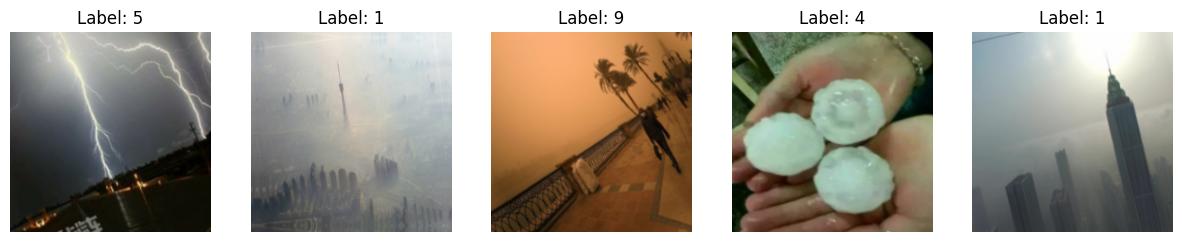

In [ ]:
# Loading raw data
# Dataset/hyperparams
sandbox_dir = pathlib.Path("../Data/Weather_Dataset")
batch_size = 32
image_size = (224, 224)  # do not change for resnet50

# Load training dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(
    sandbox_dir,
    labels='inferred',
    label_mode='int',
    validation_split=0.2,
    subset="training",
    seed=1234,
    batch_size=batch_size,
    image_size=image_size,
    shuffle=True
)
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))

# Load validation dataset
val_dataset = tf.keras.utils.image_dataset_from_directory(
    sandbox_dir,
    labels='inferred',
    label_mode='int',
    validation_split=0.2,
    subset="validation",
    seed=1234,
    batch_size=batch_size,
    image_size=image_size,
    shuffle=True
)

# print first 5 of training set
for images, labels in train_dataset.take(1):
    fig, axes = plt.subplots(1, 5, figsize=(15, 5))
    for i in range(5):
        axes[i].imshow(images[i].numpy().astype("uint8"))
        axes[i].axis("off")
        axes[i].set_title(f"Label: {labels[i].numpy()}")
    plt.show()
    break

Found 6862 files belonging to 11 classes.
Using 5490 files for training.
Found 6862 files belonging to 11 classes.
Using 1372 files for validation.
Classes: ['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']
Epoch 1/10
172/172 [==============================] - 14s 65ms/step - loss: 1.7254 - accuracy: 0.4426 - val_loss: 1.1772 - val_accuracy: 0.6224
Epoch 2/10
172/172 [==============================] - 8s 45ms/step - loss: 1.2685 - accuracy: 0.5838 - val_loss: 1.1475 - val_accuracy: 0.6232
Epoch 3/10
172/172 [==============================] - 7s 43ms/step - loss: 1.1130 - accuracy: 0.6403 - val_loss: 0.9861 - val_accuracy: 0.6851
Epoch 4/10
172/172 [==============================] - 5s 29ms/step - loss: 0.9715 - accuracy: 0.6791 - val_loss: 0.9210 - val_accuracy: 0.7019
Epoch 5/10
172/172 [==============================] - 5s 29ms/step - loss: 0.8167 - accuracy: 0.7197 - val_loss: 0.8693 - val_accuracy: 0.7252
Epoch 6/10
172/172 [=

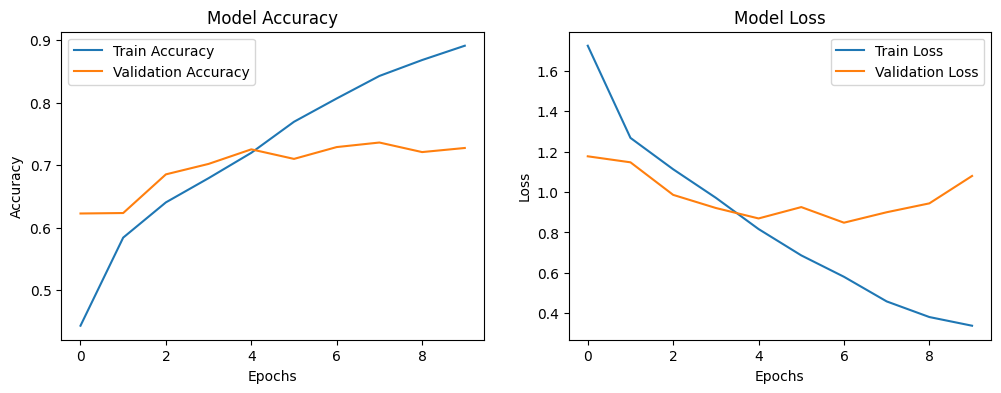

Macro-Averaged AUC: 0.9561
Macro-Averaged F1 Score: 0.7084

Classification Report:
               precision    recall  f1-score   support

         dew       0.80      0.94      0.86       139
     fogsmog       0.78      0.75      0.76       173
       frost       0.60      0.53      0.56        96
       glaze       0.70      0.58      0.64       125
        hail       0.82      0.67      0.74       106
   lightning       0.90      0.79      0.84        81
        rain       0.82      0.49      0.61       129
     rainbow       0.71      0.56      0.62        43
        rime       0.74      0.85      0.79       228
   sandstorm       0.77      0.89      0.82       143
        snow       0.45      0.66      0.54       109

    accuracy                           0.73      1372
   macro avg       0.73      0.70      0.71      1372
weighted avg       0.74      0.73      0.72      1372



In [29]:
#Raw image CNN
# Load training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    sandbox_dir,
    validation_split=0.2,
    subset="training",
    seed=1234,
    image_size=image_size,
    batch_size=batch_size
)

# Load validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    sandbox_dir,
    validation_split=0.2,
    subset="validation",
    seed=1234,
    image_size=image_size,
    batch_size=batch_size
)

# Get class names
class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)

# Normalize dataset
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.map(lambda x, y: (x / 255.0, y)).cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.map(lambda x, y: (x / 255.0, y)).cache().prefetch(buffer_size=AUTOTUNE)

# Build the CNN model
model = tf.keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D(2, 2),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Helps prevent overfitting
    layers.Dense(num_classes, activation='softmax')  # Multi-class classification
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
epochs = 10  # Adjust epochs for better performance
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

# Plot training results
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

plt.show()

# --- Compute AUC ---

# Collect predictions and true labels
y_true = []
y_probs = []

for images, labels in val_ds:
    probs = model.predict(images)
    y_probs.append(probs)
    y_true.append(labels.numpy())

# Concatenate batched outputs
y_true = np.concatenate(y_true)
y_probs = np.concatenate(y_probs)

# Convert to one-hot
y_true_onehot = tf.keras.utils.to_categorical(y_true, num_classes=num_classes)

# Compute macro-average AUC
auc = roc_auc_score(y_true_onehot, y_probs, average='macro', multi_class='ovr')
print(f"Macro-Averaged AUC: {auc:.4f}")



# Get predicted class labels (argmax of probabilities)
y_pred = np.argmax(y_probs, axis=1)

# Compute F1 score (macro-averaged for multiclass)
f1 = f1_score(y_true, y_pred, average='macro')
print(f"Macro-Averaged F1 Score: {f1:.4f}")

# Optional: Detailed classification report
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=class_names))



In [ ]:
#RUN THIS INSTEAD OF REVECTORIZING EVERY TIME
# Load the saved features and labels
data = np.load("weather_features.npz")

# Extract X (features) and y (labels)
X = data["X"]
y = data["y"]

# Print shapes to verify
print("Loaded X shape:", X.shape)
print("Loaded y shape:", y.shape)

Loaded X shape: (6860, 2048)
Loaded y shape: (6860,)


Epoch 1/20
172/172 [==============================] - 1s 4ms/step - loss: 1.1691 - accuracy: 0.6195 - val_loss: 0.5186 - val_accuracy: 0.8185
Epoch 2/20
172/172 [==============================] - 0s 2ms/step - loss: 0.5991 - accuracy: 0.8017 - val_loss: 0.4181 - val_accuracy: 0.8564
Epoch 3/20
172/172 [==============================] - 0s 2ms/step - loss: 0.4632 - accuracy: 0.8444 - val_loss: 0.3656 - val_accuracy: 0.8703
Epoch 4/20
172/172 [==============================] - 0s 2ms/step - loss: 0.4097 - accuracy: 0.8659 - val_loss: 0.3880 - val_accuracy: 0.8644
Epoch 5/20
172/172 [==============================] - 0s 2ms/step - loss: 0.3682 - accuracy: 0.8801 - val_loss: 0.3822 - val_accuracy: 0.8695
Epoch 6/20
172/172 [==============================] - 0s 2ms/step - loss: 0.3234 - accuracy: 0.8940 - val_loss: 0.3667 - val_accuracy: 0.8688
Epoch 7/20
172/172 [==============================] - 0s 2ms/step - loss: 0.3227 - accuracy: 0.8952 - val_loss: 0.3874 - val_accuracy: 0.8768
Epoch 

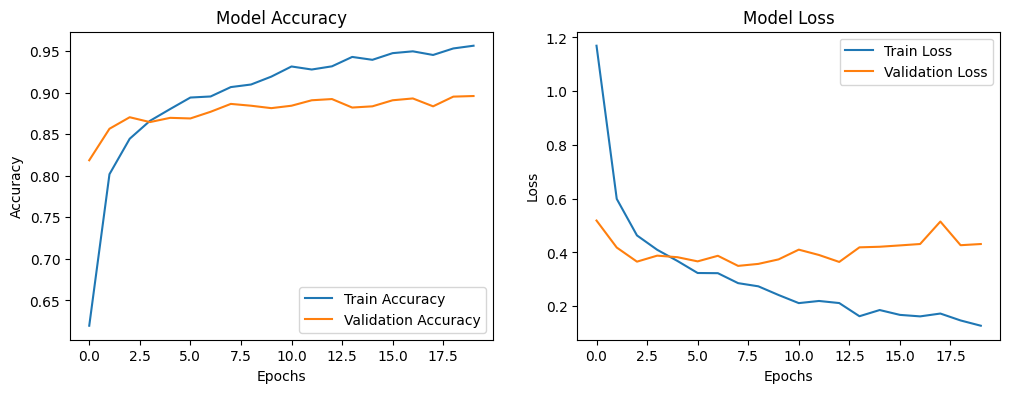


Final Validation Loss: 0.4312
Macro-Averaged AUC: 0.9923
Macro-Averaged F1 Score: 0.9023

Classification Report:
               precision    recall  f1-score   support

         dew       1.00      0.95      0.97       129
     fogsmog       0.90      0.96      0.93       182
       frost       0.89      0.73      0.80       100
       glaze       0.77      0.88      0.82       144
        hail       0.95      0.97      0.96       129
   lightning       0.98      0.97      0.98        63
        rain       0.82      0.93      0.87        95
     rainbow       0.96      0.98      0.97        47
        rime       0.87      0.87      0.87       217
   sandstorm       0.95      0.90      0.92       136
        snow       0.88      0.79      0.83       130

    accuracy                           0.90      1372
   macro avg       0.91      0.90      0.90      1372
weighted avg       0.90      0.90      0.90      1372



In [31]:
#Resnet + CNN
# Define input shape based on X dataset
input_shape = (2048,)  # Feature vector length

# Split data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1234)

# Convert labels to one-hot encoding for categorical loss
num_classes = len(set(y))  # Number of unique classes
y_train_one_hot = to_categorical(y_train, num_classes)
y_val_one_hot = to_categorical(y_val, num_classes)

# Build the Fully Connected Model
model = keras.Sequential([
    layers.Input(shape=input_shape),  # Input layer
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),  # Regularization
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')  # Output layer for multiclass classification
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
epochs = 20
history = model.fit(X_train, y_train_one_hot, 
                    validation_data=(X_val, y_val_one_hot), 
                    epochs=epochs, 
                    batch_size=32)

# Plot training results
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

plt.show()

# Predict class probabilities on validation set
y_val_probs = model.predict(X_val)

# Get predicted class labels
y_val_pred = np.argmax(y_val_probs, axis=1)

# Get true class labels
y_val_true = np.argmax(y_val_one_hot, axis=1)

# --- Final validation loss ---
final_val_loss = history.history['val_loss'][-1]
print(f"\nFinal Validation Loss: {final_val_loss:.4f}")

# --- Macro-Averaged AUC ---
auc = roc_auc_score(y_val_one_hot, y_val_probs, average='macro', multi_class='ovr')
print(f"Macro-Averaged AUC: {auc:.4f}")

# --- Macro-Averaged F1 Score ---
f1 = f1_score(y_val_true, y_val_pred, average='macro')
print(f"Macro-Averaged F1 Score: {f1:.4f}")

# --- Classification Report ---
print("\nClassification Report:\n", classification_report(y_val_true, y_val_pred, target_names=class_names))



In [32]:
#Tuning Raw CNN

# Define search space
param_grid = {
    'filters': [32, 64],
    'dense_units': [64, 128],
    'dropout_rate': [0.3, 0.5],
    'learning_rate': [1e-4, 1e-3]
}

# Create combinations of all hyperparameters
param_combinations = list(itertools.product(
    param_grid['filters'],
    param_grid['dense_units'],
    param_grid['dropout_rate'],
    param_grid['learning_rate']
))

# Load dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    sandbox_dir,
    validation_split=0.2,
    subset="training",
    seed=1234,
    image_size=image_size,
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    sandbox_dir,
    validation_split=0.2,
    subset="validation",
    seed=1234,
    image_size=image_size,
    batch_size=batch_size
)

class_names = train_ds.class_names
num_classes = len(class_names)

# Normalize and cache
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.map(lambda x, y: (x / 255.0, y)).cache().shuffle(1000).prefetch(AUTOTUNE)
val_ds = val_ds.map(lambda x, y: (x / 255.0, y)).cache().prefetch(AUTOTUNE)

# Track results
results = []

# Build model function
def build_model(filters, dense_units, dropout_rate, learning_rate):
    model = models.Sequential([
        layers.Conv2D(filters, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        layers.MaxPooling2D(2, 2),
        
        layers.Conv2D(filters * 2, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),
        
        layers.Conv2D(filters * 4, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),
        
        layers.Flatten(),
        layers.Dense(dense_units, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Grid search loop 
for filters, dense_units, dropout_rate, learning_rate in param_combinations:
    print(f"\nTraining model with filters={filters}, dense_units={dense_units}, "
          f"dropout_rate={dropout_rate}, learning_rate={learning_rate}")

    model = build_model(filters, dense_units, dropout_rate, learning_rate)
    history = model.fit(train_ds, validation_data=val_ds, epochs=10, verbose=0)

    best_val_acc = max(history.history['val_accuracy'])
    final_val_loss = history.history['val_loss'][-1]

    # Collect predictions and labels from validation set
    y_true = []
    y_probs = []

    for images, labels in val_ds:
        probs = model.predict(images, verbose=0)
        y_probs.append(probs)
        y_true.append(labels.numpy())

    y_probs = np.concatenate(y_probs)
    y_true = np.concatenate(y_true)
    y_pred = np.argmax(y_probs, axis=1)

    # One-hot encoding for AUC
    y_true_onehot = tf.keras.utils.to_categorical(y_true, num_classes=num_classes)

    # Compute metrics
    try:
        val_f1 = f1_score(y_true, y_pred, average='macro')
        val_auc = roc_auc_score(y_true_onehot, y_probs, average='macro', multi_class='ovr')
    except ValueError:
        val_f1 = None
        val_auc = None

    results.append({
        'filters': filters,
        'dense_units': dense_units,
        'dropout_rate': dropout_rate,
        'learning_rate': learning_rate,
        'best_val_accuracy': best_val_acc,
        'final_val_loss': final_val_loss,
        'val_f1': val_f1,
        'val_auc': val_auc
    })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='val_f1', ascending=False)
results_df


Found 6862 files belonging to 11 classes.
Using 5490 files for training.
Found 6862 files belonging to 11 classes.
Using 1372 files for validation.

Training model with filters=32, dense_units=64, dropout_rate=0.3, learning_rate=0.0001

Training model with filters=32, dense_units=64, dropout_rate=0.3, learning_rate=0.001

Training model with filters=32, dense_units=64, dropout_rate=0.5, learning_rate=0.0001

Training model with filters=32, dense_units=64, dropout_rate=0.5, learning_rate=0.001

Training model with filters=32, dense_units=128, dropout_rate=0.3, learning_rate=0.0001

Training model with filters=32, dense_units=128, dropout_rate=0.3, learning_rate=0.001

Training model with filters=32, dense_units=128, dropout_rate=0.5, learning_rate=0.0001

Training model with filters=32, dense_units=128, dropout_rate=0.5, learning_rate=0.001

Training model with filters=64, dense_units=64, dropout_rate=0.3, learning_rate=0.0001

Training model with filters=64, dense_units=64, dropout_rat

,filters,dense_units,dropout_rate,learning_rate,best_val_accuracy,final_val_loss,val_f1,val_auc
14,64,128,0.5,0.0001,0.758017,0.802200,0.728947,0.963277
6,32,128,0.5,0.0001,0.751458,0.821278,0.725861,0.959815
12,64,128,0.3,0.0001,0.765306,0.822102,0.720794,0.963711
8,64,64,0.3,0.0001,0.739796,0.872488,0.708052,0.958923
0,32,64,0.3,0.0001,0.733236,0.843321,0.705985,0.956689
7,32,128,0.5,0.0010,0.731778,0.986501,0.704658,0.958688
15,64,128,0.5,0.0010,0.720117,1.046288,0.702497,0.951994
5,32,128,0.3,0.0010,0.746356,1.375815,0.701898,0.950619
1,32,64,0.3,0.0010,0.725219,1.286093,0.700448,0.944872
13,64,128,0.3,0.0010,0.728863,1.476379,0.694948,0.946858


In [ ]:

# Predict class probabilities on validation set
y_val_probs = model.predict(X_val)

# Get predicted class labels
y_val_pred = np.argmax(y_val_probs, axis=1)

# Get true class labels
y_val_true = np.argmax(y_val_one_hot, axis=1)

# --- Final validation loss ---
final_val_loss = history.history['val_loss'][-1]
print(f"\nFinal Validation Loss: {final_val_loss:.4f}")

# --- Macro-Averaged AUC ---
auc = roc_auc_score(y_val_one_hot, y_val_probs, average='macro', multi_class='ovr')
print(f"Macro-Averaged AUC: {auc:.4f}")

# --- Macro-Averaged F1 Score ---
f1 = f1_score(y_val_true, y_val_pred, average='macro')
print(f"Macro-Averaged F1 Score: {f1:.4f}")

# --- Classification Report ---
print("\nClassification Report:\n", classification_report(y_val_true, y_val_pred, target_names=class_names))
